# GNN Explainer

Generate edge explanations.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle as pkl
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import ast

import torch
from tqdm import tqdm
from torch_geometric.explain import GNNExplainer, Explainer, Explanation

path = os.path.join('..', '.')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))
    
import warnings
warnings.filterwarnings('ignore')

label_size = 12
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['figure.dpi'] = 300

In [2]:
with open('datasets/x18_exp_l2_graph_dict.pkl', 'rb') as f:
    dataset = pkl.load(f)
    
# get samples in test set
test_list = [dataset['test'][i]['graph'].dataset[0] for i in dataset['test'].keys()]

### Define algorithms

In [72]:
def generate_explanation(model, test_list, ews):
    
    torch.manual_seed(42)
    np.random.seed(42)

    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(
            edge_size=0.01,
            ),
        explanation_type='model',
        # node_mask_type='common_attributes', # "common_attributes" masks each feature across all nodes
        edge_mask_type='object', #  "object" masks each edge
        model_config={
                    "mode":"binary_classification", 
                    'task_level': 'graph', 
                    'return_type': 'raw'}
    )
    # node_feature_masks = torch.Tensor([])
    edge_masks = []
    
    # iterate through each sample in the dataset
    for allele in tqdm(test_list):
        # explain for a specific graph in the dataset
        edge_weight = allele.edge_attr if ews else None
        explanation = explainer(
            allele.x, 
            allele.edge_index, 
            edge_weight = edge_weight, 
            batch = None
            )
        explanation.validate()
        # node_feature_masks = torch.cat((node_feature_masks, explanation.node_mask), dim=0)
        edge_masks.append(explanation.edge_mask)
        
    # return node_feature_masks, edge_masks
    return edge_masks

In [73]:
def get_edge_importance_df(test_list, edge_masks):

    edge_importance_dict = defaultdict(list)

    for graph, edge_mask in zip(test_list, edge_masks):
        for edge, edge_importance in zip(graph.edge_index.t(), edge_mask):
            edge = tuple(edge.tolist()) 
            edge_importance_dict[edge].append(edge_importance.item())
            
    avg_edge_importance = {edge: np.mean(importances) for edge, importances in edge_importance_dict.items()}
    edge_importance_df = pd.DataFrame(list(avg_edge_importance.items()), columns=['Edge', 'Importance'])

    return edge_importance_df

### Generate explanations for full GCN and GCN without edge weights

In [76]:
model = torch.load('../saved_models/full_model/F1=0.816_epoch=1119.pth', map_location=torch.device('cpu'))
model_no_ews = torch.load('../saved_models/control_models/final-model_no_ews-1500_epochs/F1=0.790_epoch=839.pth', map_location=torch.device('cpu'))

In [75]:
ews_edges = generate_explanation(model, test_list, ews=True)
no_ews_edges = generate_explanation(model_no_ews, test_list, ews=False)

edge_df = get_edge_importance_df(test_list, ews_edges)
no_ews_edge_df = get_edge_importance_df(test_list, no_ews_edges)

100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


In [60]:
# edge_df.to_csv('../data/edge_importance_df.csv', index=False)
# no_ews_edge_df.to_csv('../data/no_ews_edge_importance_df.csv', index=False)

### Get edge weights of test set samples

In [77]:
edge_weight_dict = defaultdict(list)

for graph in test_list:
    for edge, weight in zip(graph.edge_index.t(), graph.edge_attr):
        edge = tuple(edge.tolist()) 
        edge_weight_dict[edge].append(weight.item())


In [78]:
avg_edge_weight = {edge: np.mean(weights) for edge, weights in edge_weight_dict.items()}

In [79]:
edge_weight_df = pd.DataFrame(list(avg_edge_weight.items()), columns=['Edge', 'Weight'])

In [80]:
# edge_weight_df.to_csv('../data/edge_weight_df.csv', index=False)

### Plot Distributions

In [81]:
edge_df['Weights'] = 'Exp EWs'
no_ews_edge_df['Weights'] = 'No EWs'

In [82]:
edge_df['Normalised Importance'] = edge_df['Importance'] - edge_df['Importance'].median()
no_ews_edge_df['Normalised Importance'] = no_ews_edge_df['Importance'] - no_ews_edge_df['Importance'].median()

In [83]:
full_edge_df = pd.concat([edge_df, no_ews_edge_df])
full_edge_df

,Edge,Importance,Weights,Normalised Importance
0,"(0, 1)",0.277467,Exp EWs,0.000313
1,"(0, 2)",0.276575,Exp EWs,-0.000580
2,"(0, 39)",0.275311,Exp EWs,-0.001843
3,"(0, 40)",0.273030,Exp EWs,-0.004124
4,"(0, 41)",0.459320,Exp EWs,0.182166
...,...,...,...,...
6251,"(53, 107)",0.268551,No EWs,-0.008590
6252,"(56, 107)",0.287101,No EWs,0.009960
6253,"(107, 51)",0.475522,No EWs,0.198381
6254,"(107, 53)",0.605808,No EWs,0.328667


### Edge importance distributions - KDE Plot

Edge importance values centred about 0.

Text(0, 0.5, 'Density')

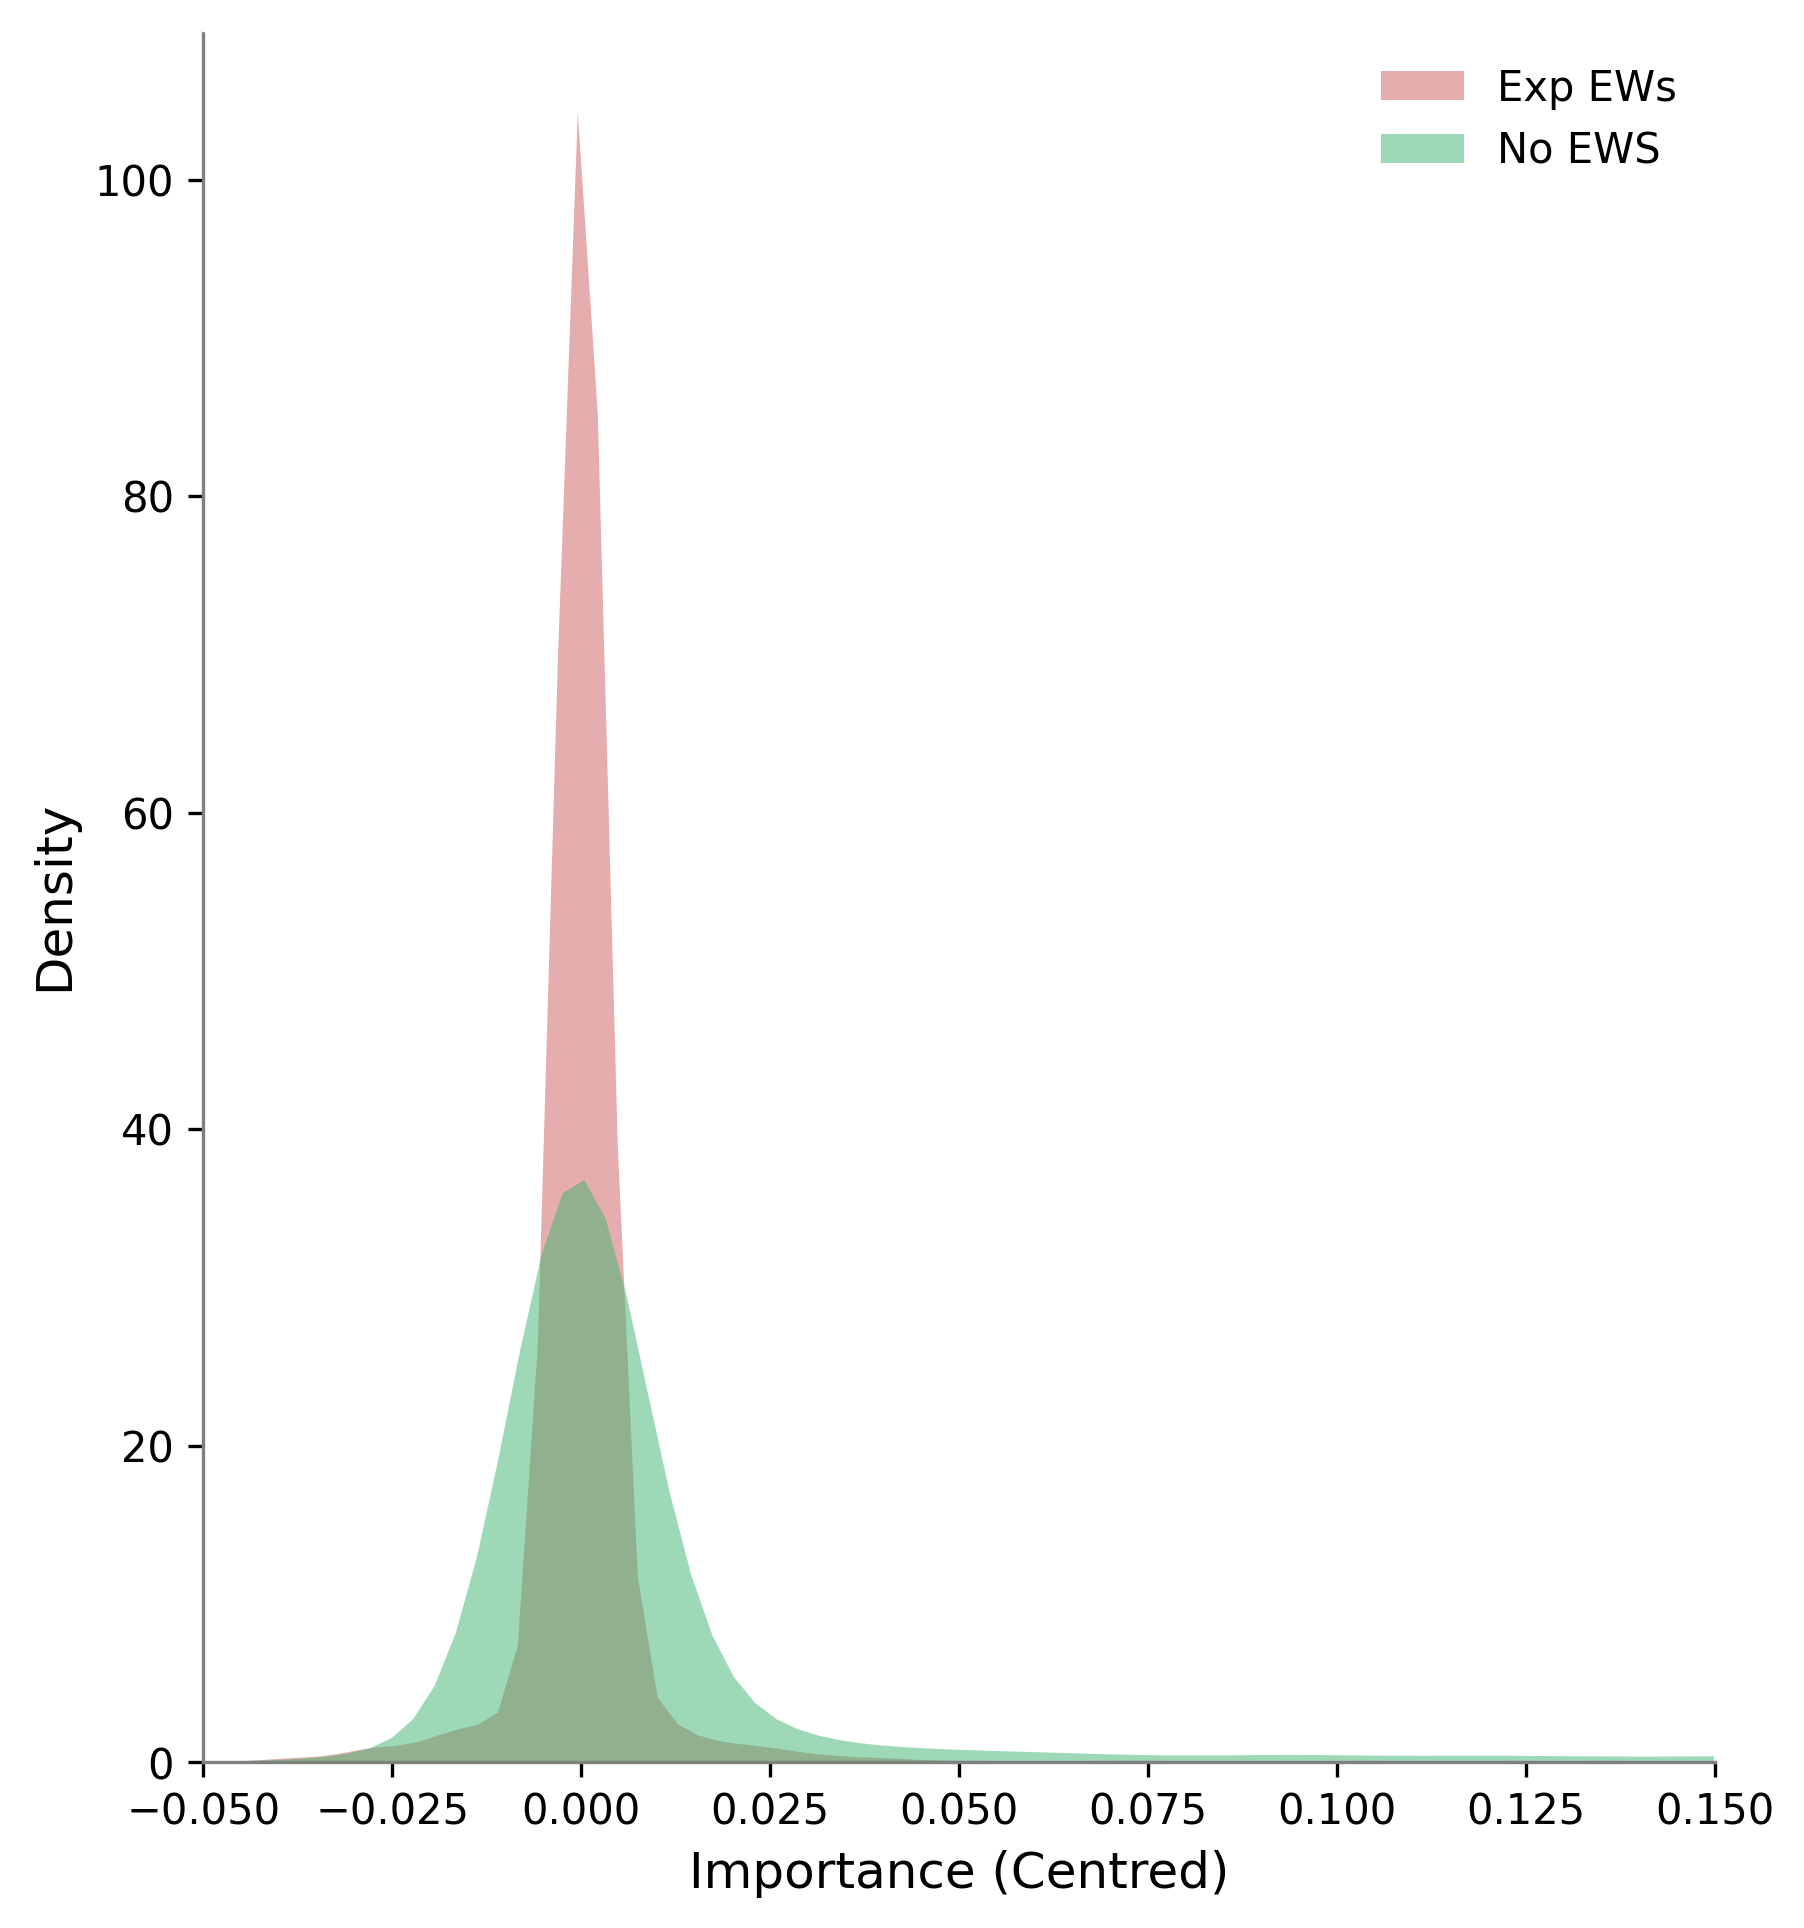

In [100]:
data = full_edge_df[['Weights', 'Normalised Importance']]

fig, ax = plt.subplots(figsize=(6.5, 7.5))

sns.kdeplot(data[data['Weights'] == 'Exp EWs']['Normalised Importance'], color='indianred', label='Exp EWs', fill=True, linewidth=0, alpha=0.5)
sns.kdeplot(data[data['Weights'] == 'No EWs']['Normalised Importance'], color='mediumseagreen', label='No EWS', fill=True, linewidth=0, alpha=0.5)


# Change figure outline color
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

legend = plt.legend(loc='upper right', frameon=False)

plt.xlim(-0.05, 0.15)
plt.xlabel('Importance (Centred)')
plt.ylabel('Density')

In [ ]:
from scipy.stats import wilcoxon

s, p = wilcoxon(data[data['Weights'] == 'Exp EWs']['Normalised Importance'], data[data['Weights'] == 'No EWs']['Normalised Importance'])
print(p)

4.063375219292983e-08


### Heatmap - Edge importance of GCN with edge weights / Edge importance of GCN without edge weights

Colour map scale kept the same for both models.

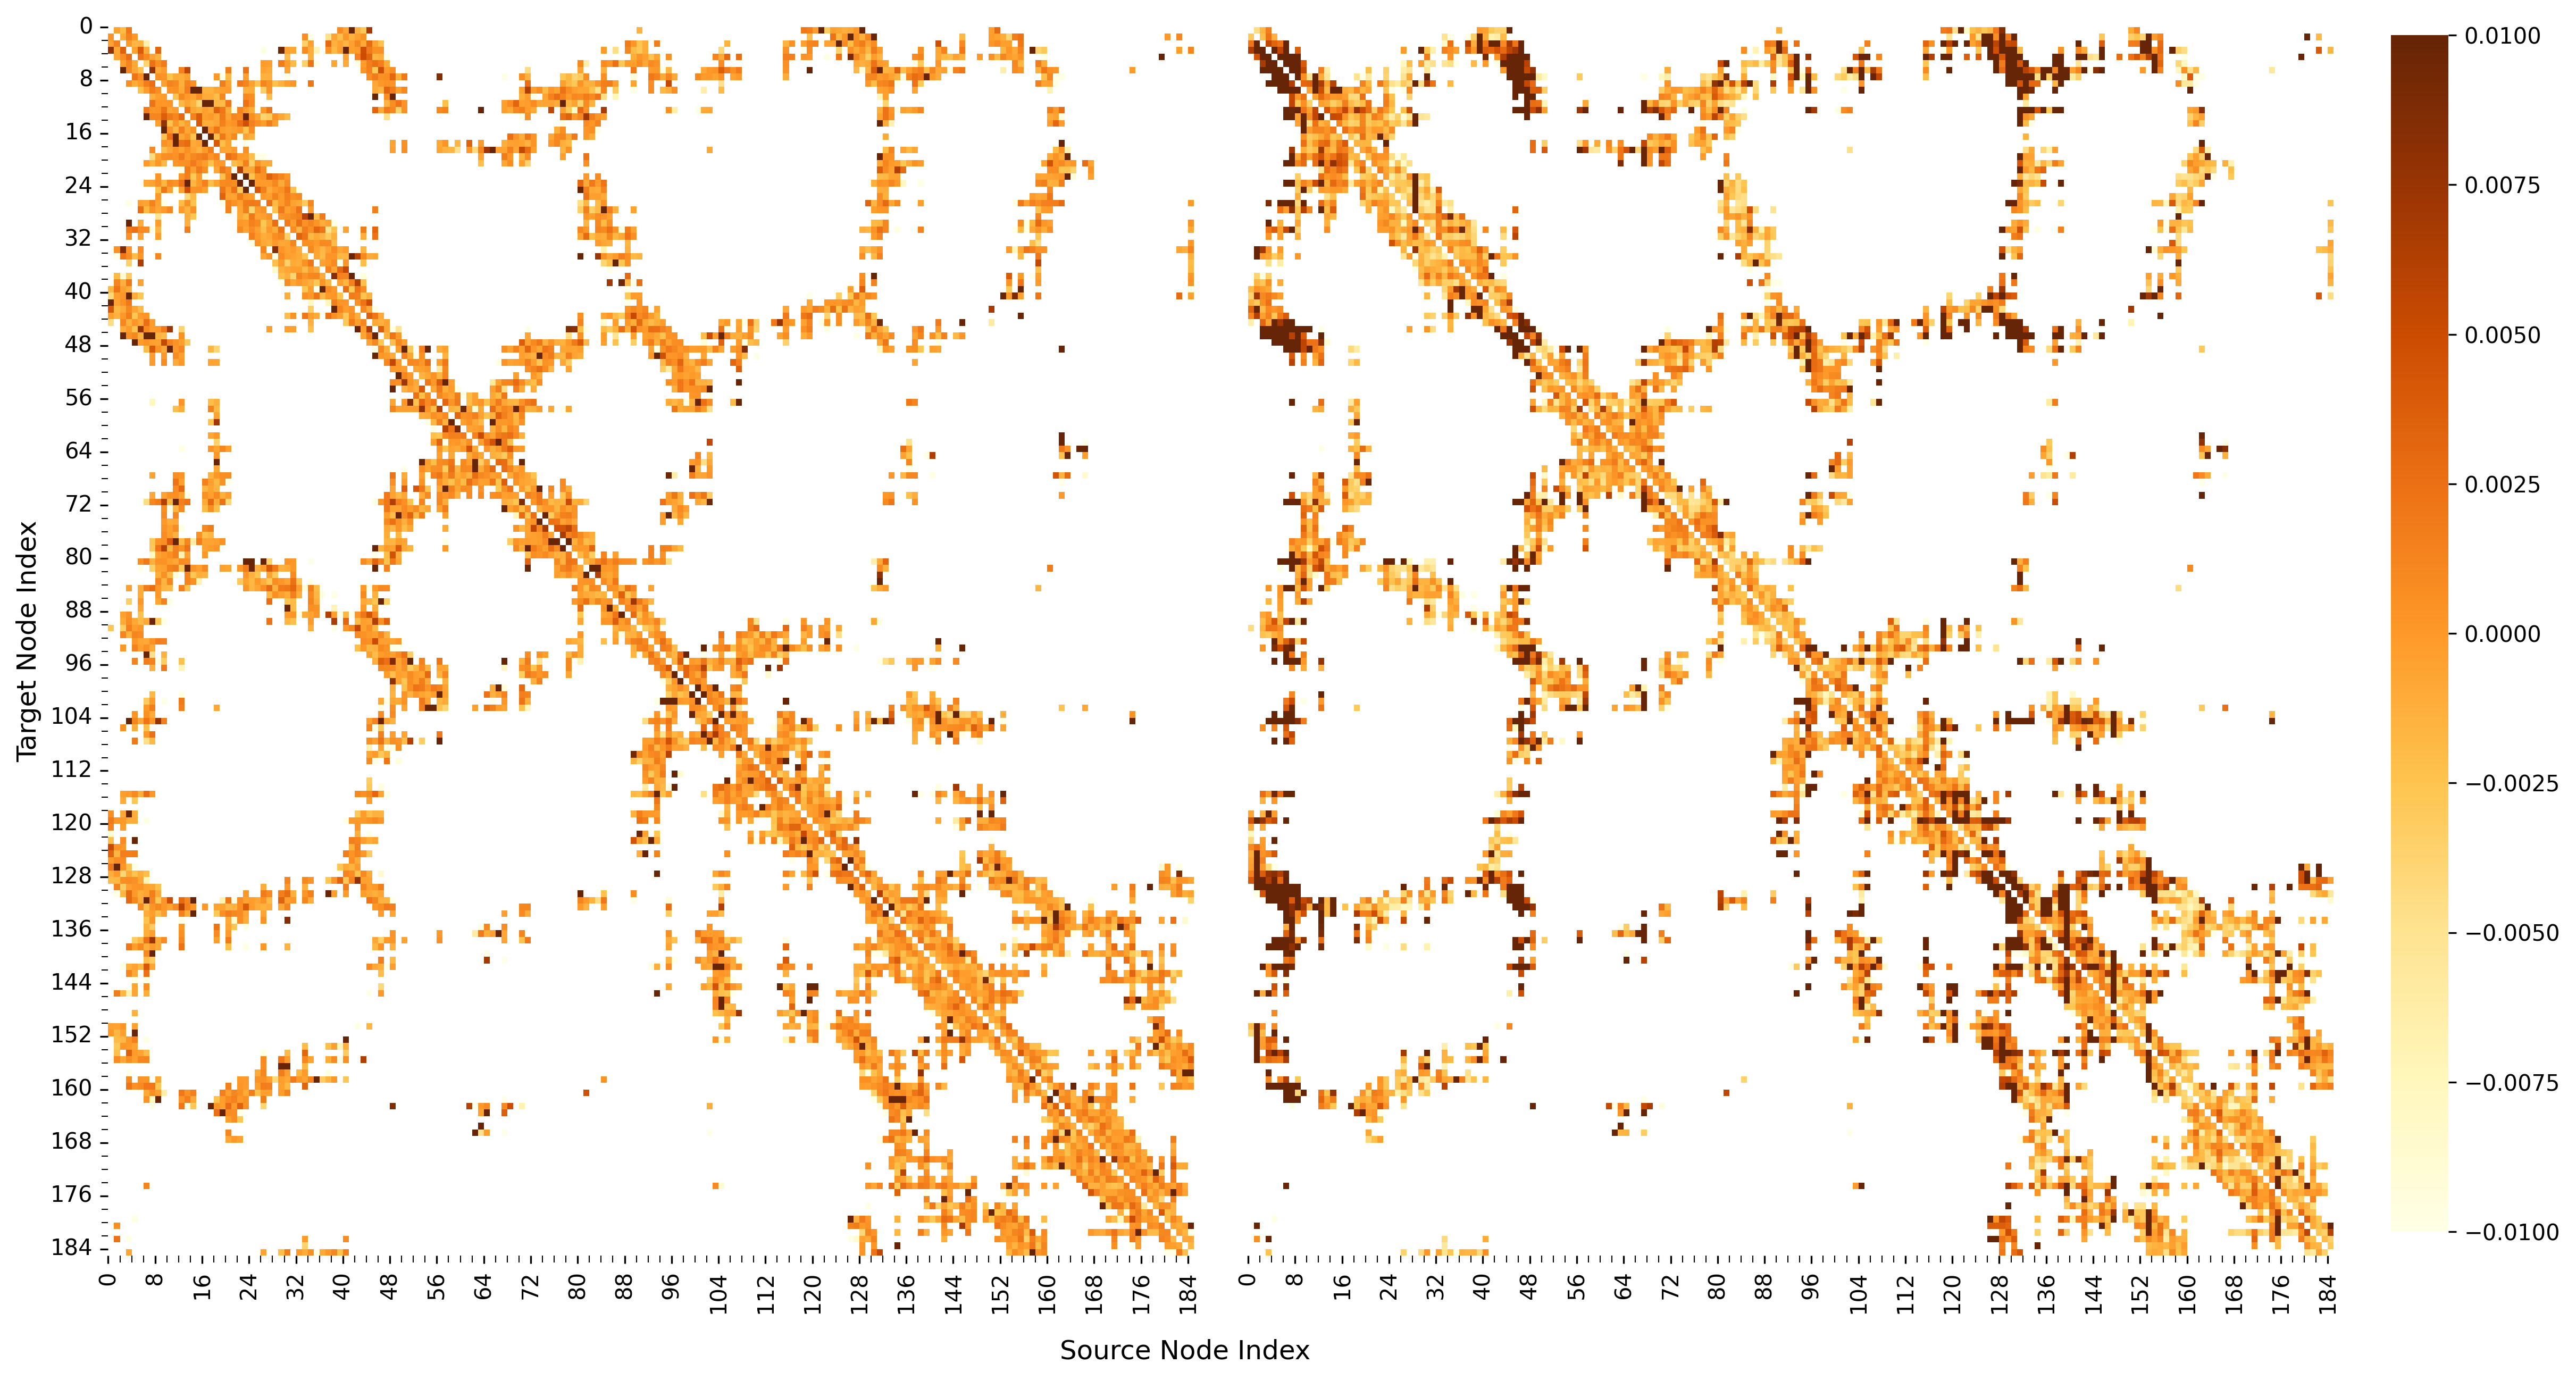

In [94]:
no_ews = full_edge_df[full_edge_df['Weights'] == 'No EWs'][['Edge', 'Normalised Importance']]
ews = full_edge_df[full_edge_df['Weights'] == 'Exp EWs'][['Edge', 'Normalised Importance']]

def ensure_tuple(edge):
    if isinstance(edge, str):
        return ast.literal_eval(edge)
    return edge

no_ews['Edge'] = no_ews['Edge'].apply(ensure_tuple)
ews['Edge'] = ews['Edge'].apply(ensure_tuple)

def edge_to_matrix(edge_df):
    nodes_x = sorted(set([e[0] for e in edge_df['Edge']]))
    nodes_y = sorted(set([e[1] for e in edge_df['Edge']]))
    matrix = pd.DataFrame(
        0, 
        index=nodes_y, 
        columns=nodes_x
    )
    for idx, row in edge_df.iterrows():
        x, y = row['Edge']
        matrix.at[y, x] = row['Normalised Importance']
    return matrix

matrix_ews = edge_to_matrix(ews)
matrix_no_ews = edge_to_matrix(no_ews)

# set 0 to nan to colour white
matrix_ews_plot = matrix_ews.replace(0, np.nan)
matrix_no_ews_plot = matrix_no_ews.replace(0, np.nan)

cmap = plt.cm.get_cmap('YlOrBr').copy()
cmap.set_bad(color='white')

# plot
fig, axes = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05})

vmin, vmax = -0.01, 0.01
tick_step = 8

# left heatmap: with ews
sns.heatmap(matrix_ews_plot, cmap=cmap, ax=axes[0], cbar=False, vmin=vmin, vmax=vmax,
            yticklabels=True, xticklabels=False)
axes[0].set_xlabel('')
axes[0].set_xticks(np.arange(0, len(matrix_ews_plot.columns), step=tick_step))
axes[0].set_xticklabels(np.arange(0, len(matrix_ews_plot.columns), step=tick_step), rotation=90)

axes[0].minorticks_on()
axes[0].tick_params(axis='x', which='minor', length=3, width=0.5)
axes[0].tick_params(axis='y', which='minor', length=3, width=0.5)

axes[0].set_xticklabels(np.arange(0, len(matrix_ews_plot.columns), step=tick_step), rotation=90)
axes[0].set_ylabel('Target Node Index')
axes[0].set_yticks(np.arange(0, len(matrix_ews_plot.index), step=tick_step)) 
axes[0].set_yticklabels(np.arange(0, len(matrix_ews_plot.index), step=tick_step), rotation=0) 

# right heatmap: no ews
cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.75])
sns.heatmap(matrix_no_ews_plot, cmap=cmap, ax=axes[1], cbar=True, vmin=vmin, vmax=vmax,
            yticklabels=False, xticklabels=True, cbar_ax=cbar_ax)

axes[1].minorticks_on()
axes[1].tick_params(axis='x', which='minor', length=3, width=0.5)
axes[1].set_xticks(np.arange(0, len(matrix_no_ews_plot.columns), step=tick_step))
axes[1].set_xticklabels(np.arange(0, len(matrix_no_ews_plot.columns), step=tick_step), rotation=90)

axes[0].set_xlabel('')
axes[1].set_xlabel('')

fig.text(0.5, 0.05, 'Source Node Index', ha='center', va='center', fontsize=label_size)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


### Edge Weight Heatmap

In [ ]:
edge_weight_df['Edge'] = edge_weight_df['Edge'].apply(ensure_tuple)

In [171]:
matrix = pd.DataFrame(
    0, 
    index=sorted(set([e[1] for e in edge_weight_df['Edge']])), 
    columns=sorted(set([e[0] for e in edge_weight_df['Edge']]))
)
for idx, row in edge_weight_df.iterrows():
    x, y = row['Edge']
    matrix.at[y, x] = np.log(row['Weight'] + 1e-8)

matrix = matrix.replace(0, -100)

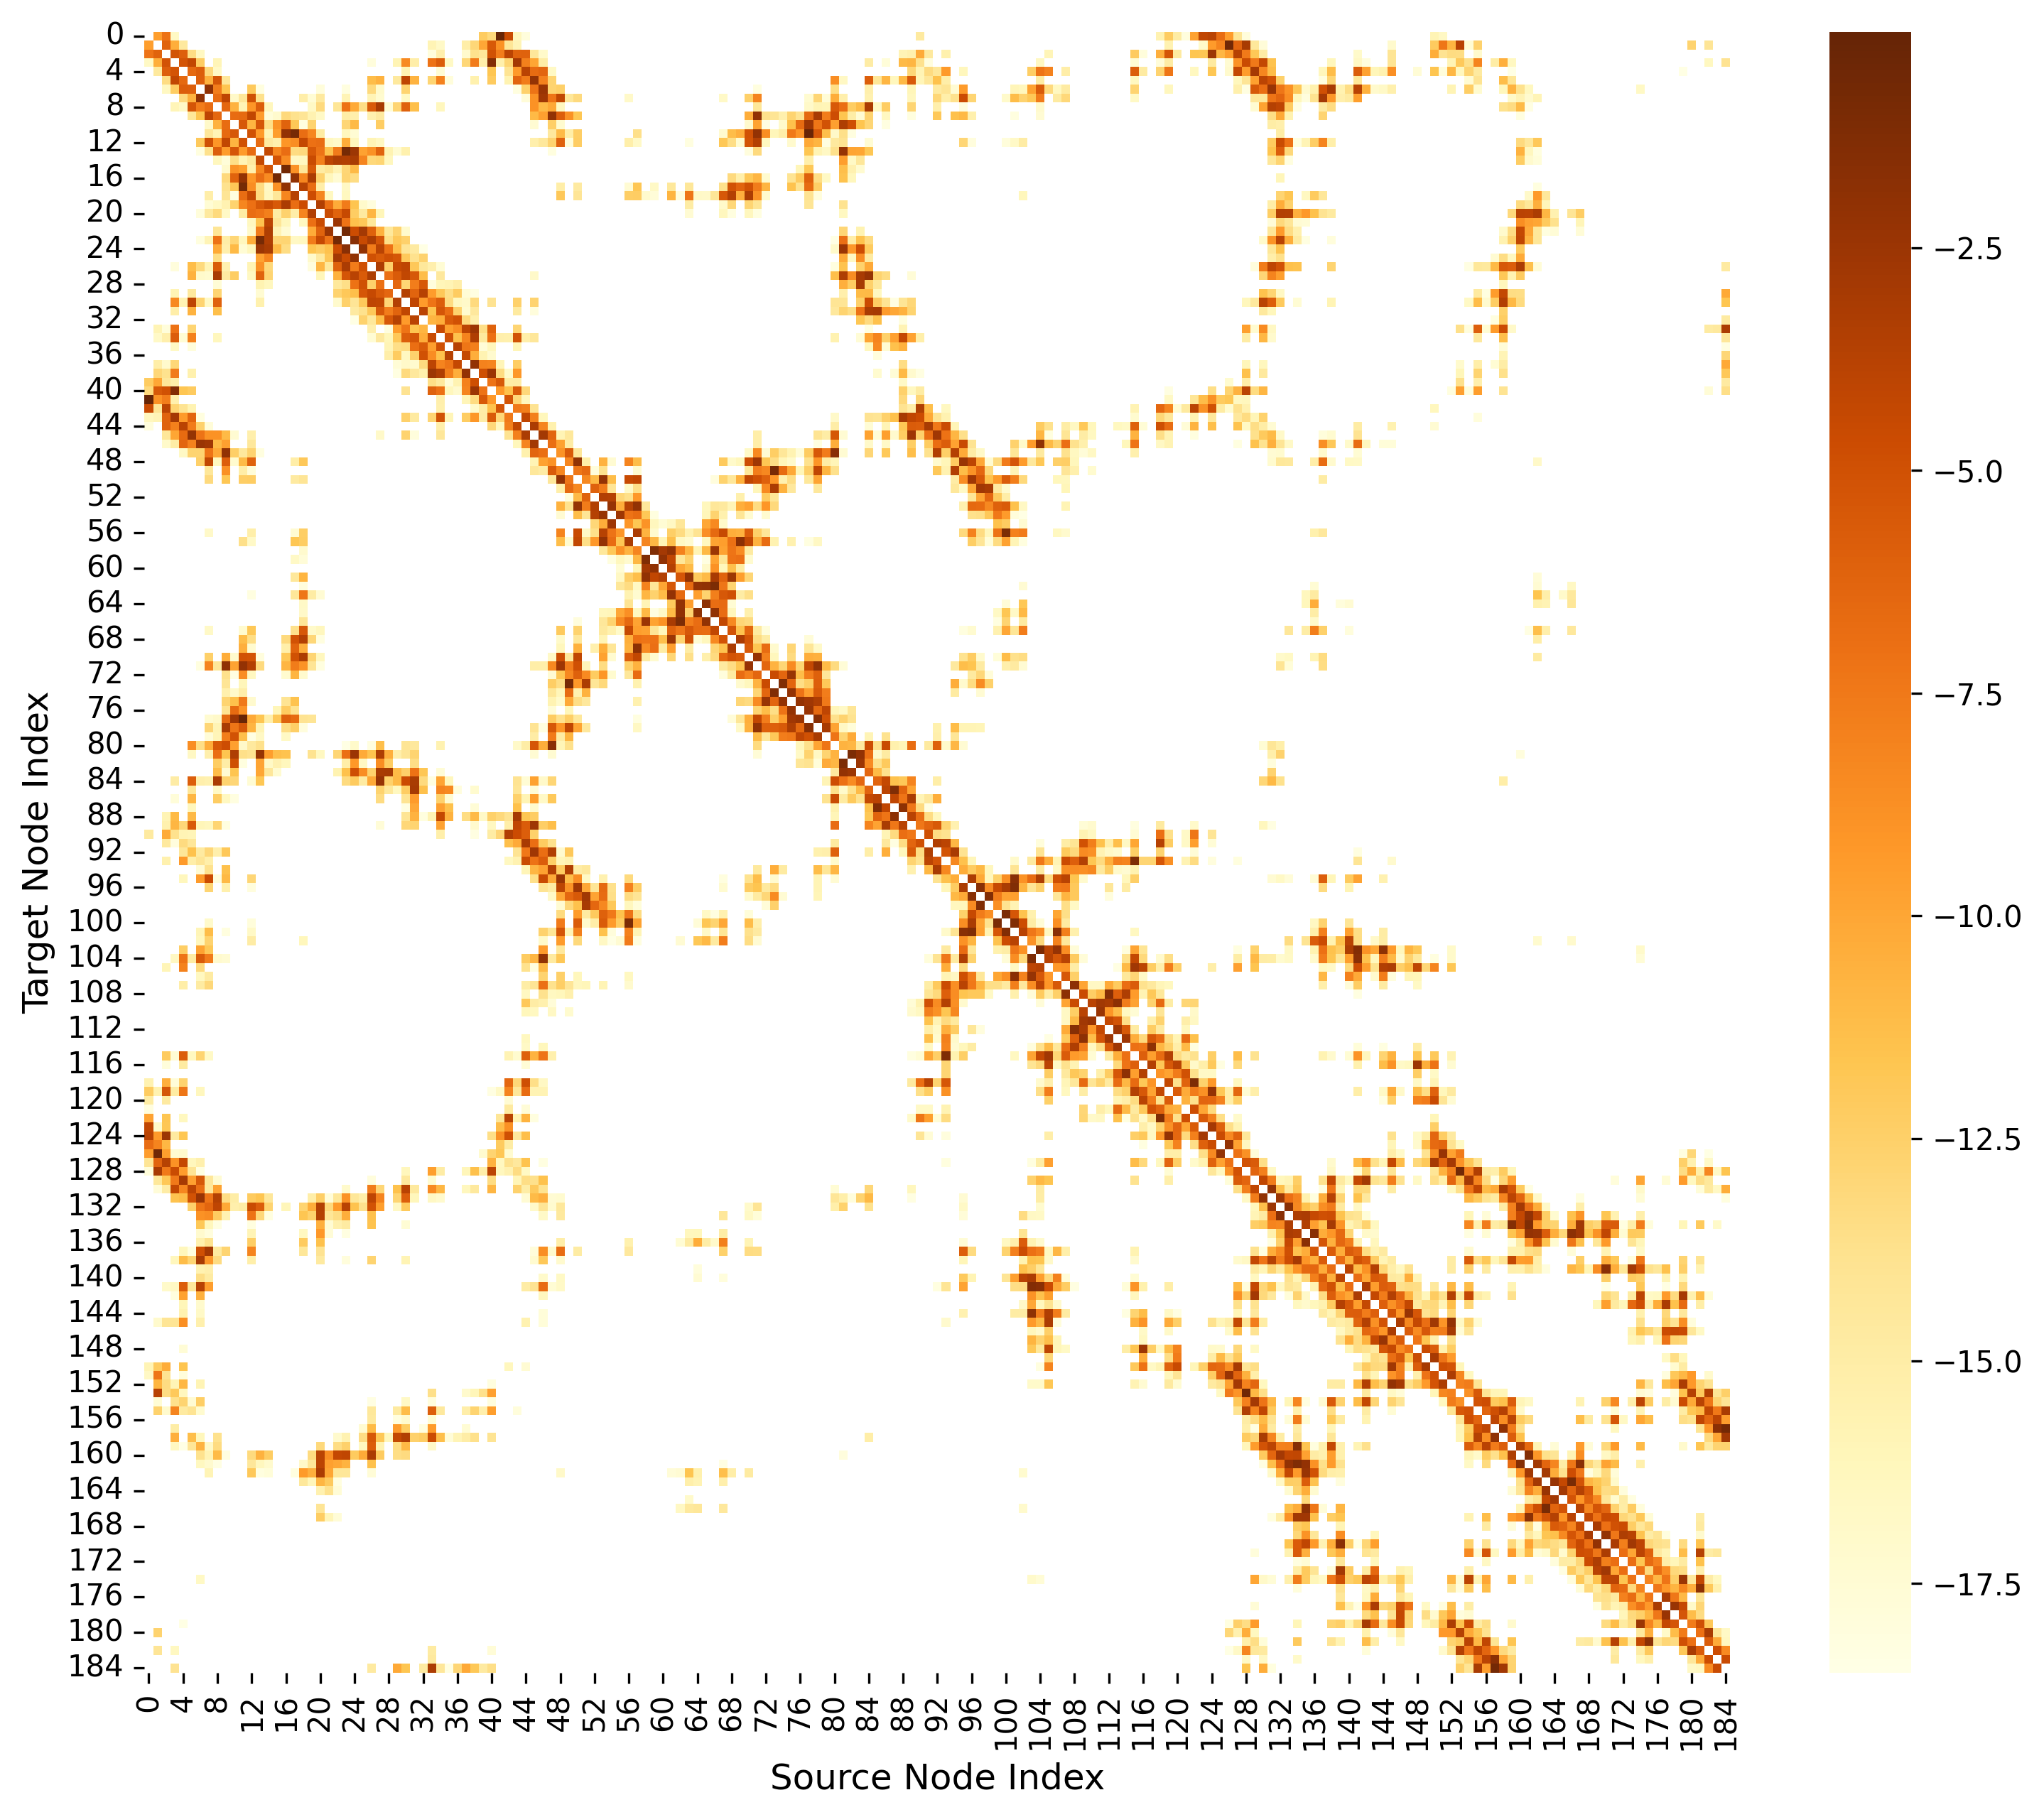

In [172]:
matrix_plot = matrix.copy()

# replace -100 with nan for white
matrix_plot = np.where(matrix_plot == -100, np.nan, matrix_plot)

cmap = plt.cm.get_cmap('YlOrBr').copy()
cmap.set_bad(color='white')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix_plot, cmap=cmap, 
            vmin=-18.5,
            vmax=-0.07)

plt.xlabel('Source Node Index')
plt.ylabel('Target Node Index')
plt.show()